# 近接原子間距離解析ツール

* 必要なライブラリの呼び出し

In [1]:
%matplotlib inline
from ipywidgets import interact
from ipywidgets import widgets
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 解析用クラス NeighborAnalyzer

In [2]:
class NeighborAnalyzer(object):
    def __init__(self, configure):
        self.centre = configure['centre']
        self.data_set = configure['data_set']
        self.max_length = configure['max_length']
        self.min_delta = configure['min_delta']
        self.max_delta = configure['max_delta']
        self.sampling_points = configure['sampling_points']
        self.delta = np.linspace(self.min_delta, self.max_delta, self.sampling_points + 1, endpoint=True)
        self.lattice_parameter = list(map(lambda x: float(x), configure['lattice_parameter']))
        sns.set_style(configure['graph_style'])

    def length(self, neighbor):
        length_array = np.zeros(len(self.delta))
        a, b, c = self.lattice_parameter
        boa = b / a
        coa = c / a
        for (i, dd) in enumerate(self.delta):
            #
            # modified for orthorhombic and tetragonal
            #
            relative_vector = neighbor(dd) - self.centre(dd)
            relative_vector[1] *= boa
            relative_vector[2] *= coa
            length_array[i] = np.linalg.norm(relative_vector)
        return length_array

    def minimum_value(self):
        neighbors = []
        for neighbor in self.data_set:
            neighbors.append(neighbor[0])
        return np.min(np.array(list(map(lambda x: self.length(x), neighbors))), axis=0)
    
    def plot_neighbors(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        for (neighbor, label, color) in self.data_set:
            ax.plot(self.delta, self.length(neighbor), label=label, color=color)
        self.set_axis()
        if self.max_length is not None:
            ax.set_ylim([0.0, self.max_length])
        fig.canvas.draw()
        
    def plot_minimum(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(self.delta, self.minimum_value(), label='nearest neighbor')
        self.set_axis()
        fig.canvas.draw()
        self.show_minimum()

    def set_axis(self):
        fontsize = 14
        plt.xlabel('$\delta$',fontsize=fontsize)
        plt.ylabel('length(a)',fontsize=fontsize)
        plt.tick_params(labelsize=fontsize)
        plt.legend(fontsize=fontsize)

    def show_minimum(self):
        min_length = self.minimum_value().min()
        a = self.lattice_parameter[0]
        print('minimum = {0:.5f}[a]'.format(min_length))
        print('        = {0:.5f}[a.u.]'.format(min_length * a))
        print('        = {0:.5f}[A^o]'.format(self.au2ang(min_length * a)))
        
    def au2ang(self, r):
        return r * 0.529177249
    
    def show_value_at(self):
        dd = (self.max_delta - self.min_delta) / (self.sampling_points + 1)
        interact(self.show_table, 
                 delta=widgets.FloatSlider(min=self.min_delta,
                                           max=self.max_delta,
                                           step=dd,
                                           readout_format='.3f'))

    
    def show_table(self, delta):
        self.delta = np.array([delta])
        a = self.lattice_parameter[0]
        labels = []
        bonds = []
        bonds_au = []
        bonds_ang = []
        for (neighbor, label, color) in self.data_set:
            labels.append(label)
            bond_length = self.length(neighbor)[0]
            bonds.append(bond_length)
            bonds_au.append(bond_length * a)
            bonds_ang.append(self.au2ang(bond_length * a))
        df = pd.DataFrame({'bond_type':labels,
                           'length(a)':np.array(bonds),
                           'length(a.u.)':np.array(bonds_au),
                           'length(A^o)':np.array(bonds_ang)}).sort_values(by='length(a)')
        df.index = range(1, len(self.data_set)+1)
        display(df[['bond_type','length(a)', 'length(a.u.)', 'length(A^o)']])

## ユーザー指定領域

### 格子定数の指定(単位はa.u.)

In [3]:
a = 19.218522

In [4]:
b = a

In [5]:
c = 19.218522

### 原子位置の設定(高階関数を使うので、関数の実態をfxxとし、オブジェクトをxxと名前づける). 原子の座標はprp.out参照

Cd:$\left(\dfrac{5}{8}, \dfrac{5}{8}, \dfrac{5}{8}\right)$

In [6]:
def fCd(delta): 
    return np.array([5.0/8.0, 5.0/8.0, 5.0/8.0])
Cd = fCd

Re:$\left(\dfrac{1}{8}, \dfrac{1}{8}, \dfrac{1}{8}\right)$

In [7]:
def fRe(delta): 
    return np.array([1.0/8.0, 1.0/8.0, 1.0/8.0])
Re = fRe

O$_1$:$\left(\dfrac{1}{2}, \dfrac{1}{2}, \dfrac{1}{2}\right)$

In [8]:
def fO1(delta):
    return np.array([0.5, 0.5, 0.5])
O1 = fO1

O$_2$:$\left(\dfrac{3}{4}, \dfrac{3}{4}, \dfrac{3}{4}\right)$

In [9]:
def fO2(delta): 
    return np.array([0.75, 0.75, 0.75])
O2 = fO2

Q$_1$:$\left(\dfrac{1}{2}, 1-x_0-\delta, \dfrac{1}{2}\right)$

In [10]:
def fQ1(delta):
    x0 = 0.1839
    return np.array([0.5, 1.0 - x0 - delta, 0.5])
Q1 = fQ1

Q$_2$:$\left(x_0 + \dfrac{1}{4} -\delta, \dfrac{3}{4}, \dfrac{3}{4}\right)$

In [11]:
def fQ2(delta):
    x0 = 0.1839
    return np.array([x0 + 0.25 - delta, 0.75, 0.75])
Q2 = fQ2

* 中心となる原子の指定

In [12]:
centre = Cd

* 周囲の原子のデータセット[関数オブジェクト, ラベル, 色]のようなデータ構造を指定する事.

In [13]:
data_set = [[Re, 'Cd-Re', 'red'],
            [O1, 'Cd-O1', 'green'],
            [Q1, 'Cd-Q1', 'blue'],
            [Q2, 'Cd-Q2', 'orange']]

### 長さの上限の設定(自動にしたいときには、max_length = NoneにしたらOK)

In [14]:
max_length = 0.8

### $\delta$の下限と(min_delta)と上限(max_delta)の設定およびその間の分割数

In [15]:
max_delta = 0.1

In [16]:
min_delta = 0.0

In [17]:
sampling_points = 10000

### グラフのスタイル(whitegrid, darkgrid, white, dark)

In [18]:
graph_style = 'whitegrid' 

### データの引き渡しと解析オブジェクトの形成

In [19]:
configure = {'centre': centre, 
             'data_set': data_set,
             'max_length': max_length,
             'min_delta': min_delta,
             'max_delta': max_delta,
             'sampling_points': sampling_points,
             'lattice_parameter':[a, b, c],
             'graph_style':graph_style}

In [20]:
analyzer = NeighborAnalyzer(configure)

* 原子毎の原子間距離のプロット

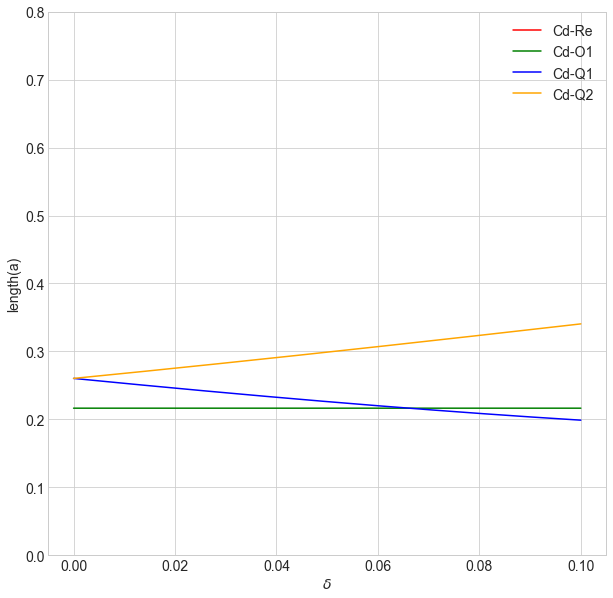

In [21]:
analyzer.plot_neighbors()

* $\delta$毎の最近接原子間距離のプロット

minimum = 0.19887[a]
        = 3.82198[a.u.]
        = 2.02251[A^o]


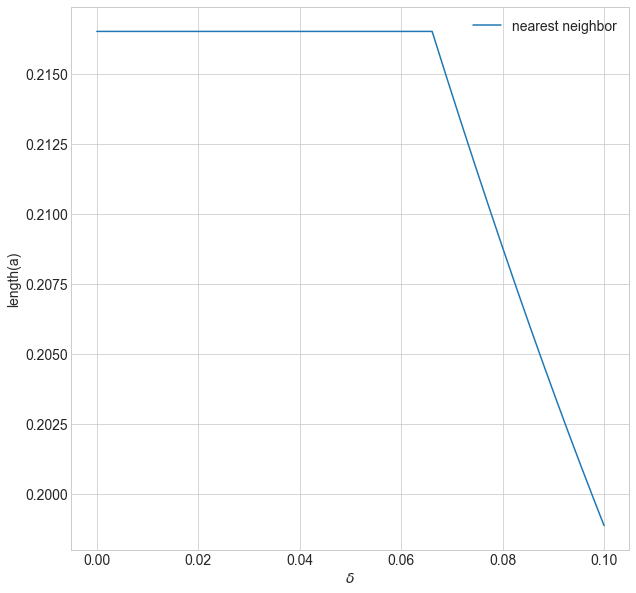

In [22]:
analyzer.plot_minimum()

* 具体的な$\delta$での原子間距離を変えて見てみる

In [23]:
analyzer.show_value_at()

interactive(children=(FloatSlider(value=0.0, description='delta', max=0.1, readout_format='.3f', step=9.999000099990002e-06), Output()), _dom_classes=('widget-interact',))

* 正確な値を知りたいときには

In [24]:
delta = 0.10

In [25]:
analyzer.show_table(delta)

bond_type  length(a)  length(a.u.)  length(A^o)
1     Cd-Q1   0.198870      3.821984     2.022507
2     Cd-O1   0.216506      4.160932     2.201871
3     Cd-Q2   0.340572      6.545288     3.463618
4     Cd-Re   0.866025     16.643728     8.807482